In [1]:
# read data: 30 ICs 
import nipype.interfaces.io as nio
import os
PD_ICA_file='/templateflow/PD_ICAs';
ICs_list=list(range(30))
ICs_list=["{:0>4d}".format(x) for x in ICs_list]
# file import
ds_ic = nio.DataGrabber(infields=['IC_id'])
ds_ic.inputs.base_directory = PD_ICA_file # database
ds_ic.inputs.template = 'melodic_IC_%4s.nii.gz' # from cwd
ds_ic.inputs.sort_filelist = True
ds_ic.inputs.IC_id = ICs_list
res_ic = ds_ic.run()
ic_list=res_ic.outputs.outfiles
# read local ic
PD_ICA_local_file='/output/PD_ICA/ICA_local/stats';
ICs_local_list=[x+1 for x in list(range(19))]
#ICs_local_list=["{:0>4d}".format(x) for x in ICs_local_list]
# file import
ds_local_ic = nio.DataGrabber(infields=['IC_id'])
ds_local_ic.inputs.base_directory = PD_ICA_local_file # database
ds_local_ic.inputs.template = 'thresh_zstat%s.nii.gz' # from cwd
ds_local_ic.inputs.sort_filelist = True
ds_local_ic.inputs.IC_id = ICs_local_list
res_local_ic = ds_local_ic.run()
ic_local_list=res_local_ic.outputs.outfiles
#print(ic_local_list)
# read data: 3 study groups by sub_list 
GROUPS=['PD','ET','NC']
OUT_DIR='/output/PD_ICA/'
SUB_LIST=[]; AGE_LIST=[]; JCOB_LIST=[];
print('Local data: ')
for group_name in GROUPS:
    current_group=group_name
    current_sub_list_file = '/codes/devel/PD_Marker/'+current_group+'_info_ICA.list'
    # create dir for output
    current_OUT_DIR=OUT_DIR+current_group+'/'
    if not os.path.exists(current_OUT_DIR):
        os.makedirs(current_OUT_DIR)
    #read sub list
    with open(current_sub_list_file, 'r') as f_sub:
        sub_list_raw= f_sub.readlines()
    sub_list = [x[0:-1].split('\t')[0] for x in sub_list_raw] # remove 
    age_list = [int(x[0:-1].split('\t')[1]) for x in sub_list_raw]
    SUB_LIST.append(sub_list);  AGE_LIST.append(age_list);
    N_sub=len(sub_list)
    print(group_name, ': ', N_sub)
    # grab group Jacobians
    ds_jacobian = nio.DataGrabber(infields=['sub_id'])
    ds_jacobian.inputs.base_directory = current_OUT_DIR # database
    ds_jacobian.inputs.template = '%s_desc-preproc_T1w_space-MNI2009c_Warp_Jacobian.nii.gz' # from cwd
    ds_jacobian.inputs.sort_filelist = True
    ds_jacobian.inputs.sub_id = sub_list
    res_jacobian = ds_jacobian.run()
    jacobian_list=res_jacobian.outputs.outfiles
    JCOB_LIST.append(jacobian_list)
pd_sub_list = SUB_LIST[0]; et_sub_list = SUB_LIST[1]; nc_sub_list = SUB_LIST[2]; 
pd_age_list = AGE_LIST[0]; et_age_list = AGE_LIST[1]; nc_age_list = AGE_LIST[2];
pd_jaco_list=JCOB_LIST[0]; et_jaco_list=JCOB_LIST[1]; nc_jaco_list=JCOB_LIST[2];
# read all the AD-subjects
import pandas as pd
sub_list_file = '/output/PPMI_DBM_AD/subject_IDs.csv'
ad_sub_list_df=pd.read_csv(sub_list_file, sep=',', header=0, index_col=0)
ad_sub_label= ['PD' if x==1 else 'NC' for x in list(ad_sub_list_df['PD'])]
N_ad_sub=len(ad_sub_label); N_ad_PD=sum(list(ad_sub_list_df['PD'])); N_ad_NC=N_ad_sub-N_ad_PD;
ad_sub_list = [str(x) for x in list(range(N_ad_sub))]
ad_jacobian_dir='/output/PPMI_DBM_AD/sub_dbm/'
ad_jacobian = nio.DataGrabber(infields=['sub_id'])
ad_jacobian.inputs.base_directory = ad_jacobian_dir # database
ad_jacobian.inputs.template = 'sub-%s_dbm.nii.gz' # from cwd
ad_jacobian.inputs.sort_filelist = True
ad_jacobian.inputs.sub_id = ad_sub_list
res_ad_jacobian = ad_jacobian.run()
ad_jacobian_list=res_ad_jacobian.outputs.outfiles
print('AD data: \nPD : ', N_ad_PD, '\nNC : ', N_ad_NC)

200925-01:46:55,936 nipype.utils WARNING:
	 A newer version (1.5.1) of nipy/nipype is available. You are using 1.5.0
Local data: 
PD :  40
ET :  29
NC :  33
AD data: 
PD :  232 
NC :  117


In [2]:
# PCA of local data (need to check)
from nilearn.decomposition import multi_pca
ICA_AB_PATH ='/output/PD_ICA/'
AB_merged_file = ICA_AB_PATH+'ICA_locallocal_pd+nc_4d.nii.gz'
ab_pca_model= multi_pca.MultiPCA(n_components=20, do_cca=True, n_jobs=-1)
ab_pca_model_fit=ab_pca_model.fit(AB_merged_file)
# PCA of AD data
ICA_AD_PATH ='/output/PPMI_DBM_AD/'
AD_merged_file = ICA_AD_PATH+'reshape_merged_dbm3_masked.nii'
from nilearn.decomposition import multi_pca
ad_pca_model= multi_pca.MultiPCA(n_components=30, do_cca=True, n_jobs=-1)
ad_pca_model_fit=ad_pca_model.fit(AD_merged_file)

In [81]:
# ad prediction in ad
ad_corr_file='ad_all-ic_mean-corr.csv'; ab_corr_file='ab_all-ic_mean-corr.csv'
ad_corr = pd.read_csv(ad_corr_file, sep=',', header=0, index_col=0)
ab_corr = pd.read_csv(ab_corr_file, sep=',', header=0, index_col=0)
import statsmodels.api as sm
import statsmodels.formula.api as smf

model1_str = 'PD ~ ic0 + ic1 + ic2 + ic3 + ic4 + ic5 + ic6 + ic7 + ic8 + ic9 + ic10 + ic11 + ic12 + ic13 + ic14 + ic15 + ic16 + ic17 + ic18 + ic19 + ic20 + ic21 + ic22  + ic23 + ic24 + ic25 + ic26 + ic27 + ic28 + ic29'
model2_str = 'PD ~ ic0 + ic1 + ic2 + ic3 + ic4 + ic5 + ic6 + ic7'

model1_fit = smf.glm(model1_str, ad_corr, family=sm.families.Binomial(link=sm.families.links.logit)).fit()
model2_fit = smf.glm(model2_str, ad_corr, family=sm.families.Binomial(link=sm.families.links.logit)).fit()

#print(model1_fit.summary())
#print(model2_fit.summary())
ab_corr.columns

/usr/local/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  if sys.path[0] == '':


Index(['ic0', 'ic1', 'ic2', 'ic3', 'ic4', 'ic5', 'ic6', 'ic7', 'ic8', 'ic9',
       'ic10', 'ic11', 'ic12', 'ic13', 'ic14', 'ic15', 'ic16', 'ic17', 'ic18',
       'ic19', 'ic20', 'ic21', 'ic22', 'ic23', 'ic24', 'ic25', 'ic26', 'ic27',
       'ic28', 'ic29', 'label', 'PD', 'ID'],
      dtype='object')

In [82]:
# svm classification
import numpy as np
from sklearn.model_selection import train_test_split

N_ic=len(ic_list)
X=ad_corr.iloc[:,0:30];
y=ad_corr['PD'];
print(X.shape, y.shape)

clf = svm.SVC(kernel='sigmoid', C=1).fit(X_train, y_train)
clf.score(X_test, y_test)
clf = svm.SVC(kernel='sigmoid', C=1)
scores = cross_val_score(clf, X, y, cv=10)
scores
#print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

(349, 30) (349,)


array([0.62857143, 0.57142857, 0.62857143, 0.54285714, 0.68571429,
       0.6       , 0.54285714, 0.62857143, 0.65714286, 0.52941176])

In [94]:
N_ab_PD=len(pd_sub_list); N_ab_ET=len(et_sub_list); 
N_ab_NC=len(nc_sub_list); 
def cv_score(X, N_ic, N_cv):
    from sklearn import svm
    from sklearn.model_selection import cross_val_score
    m_list=[]; v_list=[];
    for i_ic in range(1,N_ic+1):
        x_mat=X.iloc[:,0:i_ic]; y=X['PD'];
        clf = svm.SVC(kernel='sigmoid', C=1)
        scores = cross_val_score(clf, x_mat, y, cv=N_cv)
        m_list.append(scores.mean())
        v_list.append(scores.std())
    return m_list, v_list
N_cv=10


Text(0.5, 0, 'AD ICs')

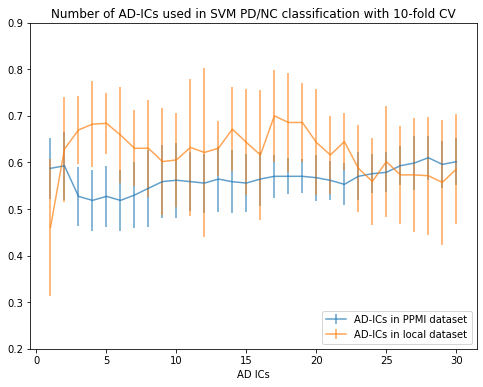

In [100]:
# AD ic in PN/NC
import matplotlib.pyplot as plt
ad_mean, ad_var = cv_score(ad_corr, N_ic, N_cv)
ab_mean, ab_var = cv_score(ab_corr.iloc[0:N_ab_PD+N_ab_NC,:], N_ic, N_cv)
x = list(range(1, N_ic+1))
fig = plt.figure(figsize=[8, 6])
plt.errorbar(x, ad_mean, yerr=ad_var, alpha=.7, label='AD-ICs in PPMI dataset')
plt.errorbar(x, ab_mean, yerr=ab_var, alpha=.7, label='AD-ICs in local dataset')
plt.legend(loc='lower right')
plt.title('Number of AD-ICs used in SVM PD/NC classification with 10-fold CV')
plt.ylim(0.2, 0.9)
plt.xlabel('PPMI ICs')

Text(0.5, 0, 'AD ICs')

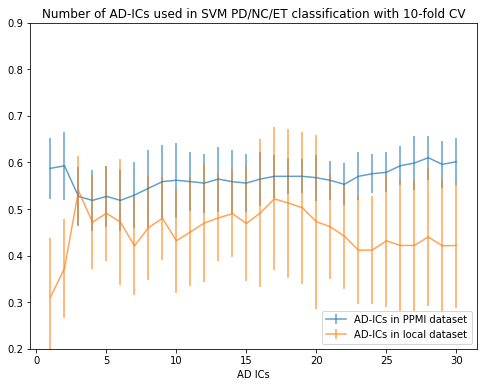

In [101]:
# AD IC for PD/NC/ET
import matplotlib.pyplot as plt
ad_mean, ad_var = cv_score(ad_corr, N_ic, N_cv)
ab_mean, ab_var = cv_score(ab_corr, N_ic, N_cv)
x = list(range(1, N_ic+1))
fig = plt.figure(figsize=[8, 6])
plt.errorbar(x, ad_mean, yerr=ad_var, alpha=.7, label='AD-ICs in PPMI dataset')
plt.errorbar(x, ab_mean, yerr=ab_var, alpha=.7, label='AD-ICs in local dataset')
plt.legend(loc='lower right')
plt.title('Number of AD-ICs used in SVM PD/NC/ET classification with 10-fold CV')
plt.ylim(0.2, 0.9)
plt.xlabel('PPMI ICs')

Text(0.5, 0, 'Local ICs')

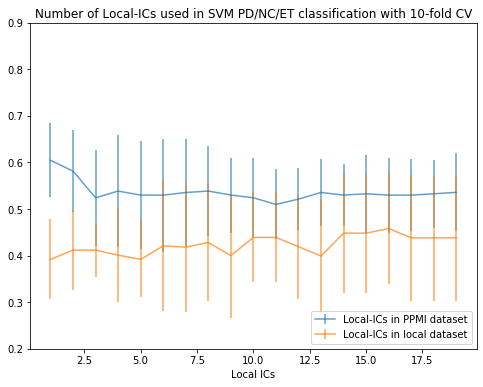

In [104]:
# local IC for PD/NC/ET
ab_ad_corr_file='abxad-ic_mean-corr.csv'; ab_ab_corr_file='abxab-ic_mean-corr.csv'
ab_ad_corr = pd.read_csv(ab_ad_corr_file, sep=',', header=0, index_col=0)
ab_ab_corr = pd.read_csv(ab_ab_corr_file, sep=',', header=0, index_col=0)
import matplotlib.pyplot as plt
N_ic_ab=len(ic_local_list)
ab_ad_mean, ab_ad_var = cv_score(ab_ad_corr, N_ic_ab, N_cv)
ab_ab_mean, ab_ab_var = cv_score(ab_ab_corr, N_ic_ab, N_cv)
x = list(range(1, N_ic_ab+1))
import matplotlib.pyplot as plt
fig = plt.figure(figsize=[8, 6])
plt.errorbar(x, ab_ad_mean, yerr=ab_ad_var, alpha=.7, label='Local-ICs in PPMI dataset')
plt.errorbar(x, ab_ab_mean, yerr=ab_ab_var, alpha=.7, label='Local-ICs in local dataset')
plt.legend(loc='lower right')
plt.title('Number of Local-ICs used in SVM PD/NC/ET classification with 10-fold CV')
plt.ylim(0.2, 0.9)
plt.xlabel('Local ICs')

Text(0.5, 0, 'Local ICs')

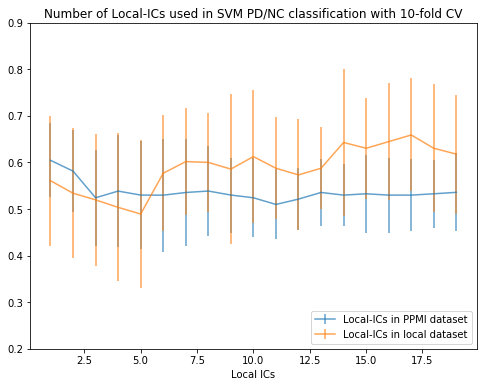

In [108]:
# local IC for PD/NC
import matplotlib.pyplot as plt
ab_ad_mean, ab_ad_var = cv_score(ab_ad_corr, N_ic_ab, N_cv)
ab_ab_mean, ab_ab_var = cv_score(ab_ab_corr.iloc[0:N_ab_PD+N_ab_NC,:], N_ic_ab, N_cv)
x = list(range(1, N_ic_ab+1))
fig = plt.figure(figsize=[8, 6])
plt.errorbar(x, ab_ad_mean, yerr=ab_ad_var, alpha=.7, label='Local-ICs in PPMI dataset')
plt.errorbar(x, ab_ab_mean, yerr=ab_ab_var, alpha=.7, label='Local-ICs in local dataset')
plt.legend(loc='lower right')
plt.title('Number of Local-ICs used in SVM PD/NC classification with 10-fold CV')
plt.ylim(0.2, 0.9)
plt.xlabel('Local ICs')

In [ ]:
ad_mean, ad_var = cv_score(ad_corr, N_ic, N_cv)
ab_mean, ab_var = cv_score(ab_corr, N_ic, N_cv)
x = list(range(1, N_ic+1))
fig = plt.figure(figsize=[8, 6])
plt.errorbar(x, ad_mean, yerr=ad_var, alpha=.7, label='AD-ICs in PPMI dataset')
plt.errorbar(x, ab_mean, yerr=ab_var, alpha=.7, label='AD-ICs in local dataset')
plt.legend(loc='lower right')
plt.title('Number of AD-ICs used in SVM PD/NC/ET classification with 10-fold CV')
plt.ylim(0.2, 0.9)
plt.xlabel('Local ICs')

In [ ]:
# prediction with cross-validation GLM-GAM, still have problems
import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines
import numpy as np

# import data
#In [3]: from statsmodels.gam.tests.test_penalized import df_autos
# create spline basis for weight and hp
#In [4]: x_spline = df_autos[['weight', 'hp']]
#In [5]: bs = BSplines(x_spline, df=[12, 10], degree=[3, 3])
# penalization weight
alpha = np.array([21833888.8, 6460.38479])
gam_bs = GLMGam.from_formula(model2_str, data=model1_fit)
res_bs = gam_bs.fit()
print(res_bs.summary())
gam_bs.select_penweight()[0]
gam_bs.select_penweight_kfold()[0]

In [16]:
# import necessary modules:
import numpy as np
import pandas as pd
import patsy
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats as sm_stats
import matplotlib.pyplot as plt



In [19]:
%matplotlib inline
# read MELODIC PCA
import nibabel as nib
tmp_img='/output/PPMI_DBM_AD/AD-ICA/melodic_pca.nii.gz'
tmp_img2='/output/PPMI_DBM_AD/AD-ICA/melodic_IC.nii.gz'
tmp_img1='/output/PD_ICA/ICA_local/melodic_pca.nii.gz'
tmp_img3='/output/PD_ICA/ICA_local/melodic_IC.nii.gz'
pca_melodic_ad=nib.load(tmp_img)
pca_melodic_ab=nib.load(tmp_img1)
ica_melodic_ad=nib.load(tmp_img2)
ica_melodic_ab=nib.load(tmp_img3)
print(pca_melodic_ab.shape, pca_melodic_ad.shape, ica_melodic_ad.shape,ica_melodic_ab.shape )

(193, 229, 193, 19) (101, 119, 97, 30) (101, 119, 97, 30) (193, 229, 193, 19)


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sklearn

# Import necessary modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeavePOut
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold

In [ ]:
# ML prediction
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
X=
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
clf.score(X_test, y_test)

In [ ]:
# IC*PD/NC mean
IC_INDEX = ['ic'+str(x) for x in range(30)]
PD_mean = pd.read_csv('mean_all_pd.csv', sep=',', header=0, index_col=0)
PD_mean.index= IC_INDEX
PD_mean.columns = pd_sub_list
PD_mean=PD_mean.T
PD_mean['age']=pd_age_list
NC_mean = pd.read_csv('mean_all_nc.csv', sep=',', header=0, index_col=0, usecols=list(range(21))+list(range(22,35,1)))
NC_mean.index= IC_INDEX
NC_mean.columns = nc_sub_list
NC_mean=NC_mean.T
NC_mean['age']=nc_age_list
#print(NC_mean.columns)
Labels = [1]*len(pd_sub_list)+[0]*len(nc_sub_list)
data_all = PD_mean.append(NC_mean)
data_all['LABEL']=Labels
print(data_all.columns)
#PD_mean.boxplot(column=IC_INDEX, grid=False)
#NC_mean.boxplot(column=IC_INDEX, grid=False)

In [40]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

fit_lm = smf.glm('LABEL ~ ic0 + ic1 + ic2 + ic3 + ic4 + ic5 + ic6 + ic7 + ic8 + ic9 + ic10 + ic11 + ic12 + ic13 + ic14 + ic15 + ic16 + ic17 + ic18 + ic19 + ic20 + ic21 + ic22  + ic23 + ic24 + ic25 + ic26 + ic27 + ic28 + ic29 + age', data_all, \
                 family=sm.families.Binomial(link=sm.families.links.logit)).fit()
print(fit_lm.summary())

fit_lm1 = smf.glm('LABEL ~ ic0 + ic1 + ic2 + ic3 + ic4 + ic5 + ic6 + ic7 + age', data_all, \
                 family=sm.families.Binomial(link=sm.families.links.logit)).fit()
fit_lm1.predi
print(fit_lm1.summary())
fit_lm.predict(exog=data_all)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  LABEL   No. Observations:                   73
Model:                            GLM   Df Residuals:                       41
Model Family:                Binomial   Df Model:                           31
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -21.667
Date:                Fri, 18 Sep 2020   Deviance:                       43.334
Time:                        12:02:33   Pearson chi2:                     68.2
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.3144      4.742     -1.332      0.1

/usr/local/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  """
/usr/local/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  if __name__ == '__main__':


AttributeError: 'GLMResults' object has no attribute 'predi'

In [45]:
def n
x=fit_lm.predict(exog=data_all)

Intercept    -6.314407
ic0         -76.107733
ic1         -38.929635
ic2         -64.428637
ic3          10.870359
ic4          56.018398
ic5          40.652611
ic6          30.470969
ic7           0.949538
ic8         -34.171692
ic9          88.742838
ic10         69.763064
ic11         38.102221
ic12         64.922071
ic13         32.421756
ic14        -33.663676
ic15         31.719457
ic16        -52.648120
ic17        -22.024840
ic18        -29.190861
ic19         42.154004
ic20        -10.017445
ic21         15.575214
ic22         39.332623
ic23        -15.897673
ic24         30.394926
ic25         15.848131
ic26        -18.101645
ic27         82.280366
ic28          7.003832
ic29          5.701881
age           0.057928
dtype: float64

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  LABEL   No. Observations:                   73
Model:                            GLM   Df Residuals:                       70
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -47.652
Date:                Fri, 11 Sep 2020   Deviance:                       95.305
Time:                        11:36:01   Pearson chi2:                     77.0
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.4322      1.352     -1.799      0.0

/usr/local/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  


5.373972038621097e-109

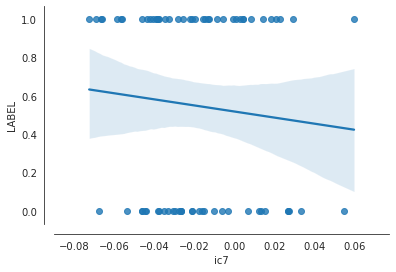

In [120]:
fit_lm2 = smf.glm('LABEL ~ ic7 + age', data_all, \
                 family=sm.families.Binomial(link=sm.families.links.logit)).fit()
print(fit_lm2.summary())
# Let's have a look at the model predictions
sns.regplot('ic7', 'LABEL', data_all)
sns.despine(offset=10);
#
def logit(x):
    return(1. / (1. + np.exp(-x)))
age = 65
linear_predictor = fit_lm2.params[0] + fit_lm2.params[-2]*age
linear_predictor
pred=logit(linear_predictor)
pred

In [ ]:
# calculate image naive corr
import nibabel as nib
import numpy as np
import time
i_PD_IC=7
PD_ICA_img=nib.load(ic_list[i_PD_IC]);
def cal_groupCorr(ic_img, img_list):
    import nibabel as nib
    from nilearn.image import resample_to_img
    from nilearn.image import math_img
    from scipy import stats
    x_list=[];
    N_sub=len(img_list)
    for i in range(N_sub):
        sub_img=nib.load(img_list[i])
        sub_img_re= resample_to_img(sub_img, ic_img)
        ic_data = ic_img.get_fdata().reshape(-1);
        nz_pos=np.flatnonzero(ic_data)
        ic_val=list(ic_data.ravel()[nz_pos])
        sub_dat = sub_img_re.get_fdata().reshape(-1);
        sub_val=list(stats.zscore(sub_dat.ravel()[nz_pos]))
        x_list.append(np.corrcoef(sub_val, ic_val)[0,1])
    return x_list
t0=time.time()
pd_jaco_corr_list=[cal_groupCorr(nib.load(x), pd_jaco_list) for x in ic_list]; 
et_jaco_corr_list=[cal_groupCorr(nib.load(x), et_jaco_list) for x in ic_list]; 
nc_jaco_corr_list=[cal_groupCorr(nib.load(x), nc_jaco_list) for x in ic_list]; 
print("naive corr of 3 groups take: ", str(time.time()-t0))

In [ ]:
#vis for naive corr
import numpy as np
def plot_corrICA(a, b, c):
    al=np.zeros(len(a)); bl=np.zeros(len(b)); cl=np.zeros(len(c));
    x=list(range(al+bl+cl))
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_title('Group element-wise correlation', color='C0')
    ax.plot(x[0:al-1], a,  label='PD: '+str(round(np.mean(a),4))+'~'+str(round(np.std(a),4)))
    ax.plot(x[al:al+bl-1],b ,  label='NC: '+str(round(np.mean(b),4))+'~'+str(round(np.std(b),4)))
    ax.plot(x[al+bl:al+bl+cl-1], c,  label='ET: '+str(round(np.mean(c),4))+'~'+str(round(np.std(c),4)))
    ax.legend()
plot_corrICA(pd_jaco_corr_list[], nc_jaco_corr_list[], et_jaco_corr_list[])

In [3]:
import statsmodels
import nistats

ModuleNotFoundError: No module named 'nistats'

In [ ]:
from scipy import stats
print('T-test for PD vs NC', stats.ttest_ind(rvs1,rvs2))
print('T-test for PD vs NC', stats.ttest_ind(rvs1,rvs2))

In [ ]:
grou_names=['PD']*len(pd_jaco_x_list_mean)+['ET']*len(et_jaco_x_list_mean)+['NC']*len(nc_jaco_x_list_mean);
age=pd_age_list+et_age_list+nc_age_list;
group_ica_mean=pd_jaco_x_list_mean+et_jaco_x_list_mean+nc_jaco_x_list_mean;
import pandas as pd
df_1=pd.DataFrame({'group':grou_names, 'age':age, 'ica_mean': group_ica_mean})
# generate a boxplot to see the data distribution by genotypes and years. Using boxplot, we can easily detect the 
# differences between different groups
#sns.boxplot(x="group", y="age", hue="ica_mean", data=df_1, palette="Set3") 
#df_1.to_csv('data.csv')
print(df_1)

In [19]:
import pandas as pd
df_1=pd.read_csv('data.csv')
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Ordinary Least Squares (OLS) model
# C(Genotype):C(years) represent interaction term
model= ols('ica_mean ~ (group) + (age) + (group):(age)', data=df_1).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
model1= ols('ica_mean ~ (group) + (age)', data=df_1).fit()
anova_table1 = sm.stats.anova_lm(model1, typ=3)

<KeysViewHDF5 ['HDFVersion', 'ITKVersion', 'OSName', 'OSVersion', 'TransformGroup']>
<KeysViewHDF5 ['TransformType']>


In [ ]:
print(anova_table)
print(model.conf_int())
print(anova_table1)
print(model1.conf_int())

print(model.aic, model.bic)
print(model1.aic, model1.bic)
